In [2]:
''' Notebook with basic behavioral analysis plots from DIOs'''

import os
import yaml

import numpy as np
import pandas as pd
import pynapple as nap


from jlab_nwb import JLabNWBHandler
from dios import DIO, DIOs
import Utils.epoch_tools as ep_tools
import Beh.plot_behavior as BehGraph
from  analyze_one_rec_settings import import_one_rec_settings

In [2]:
# Autoreloader Magic Fns
%load_ext autoreload
%autoreload 1
%aimport jlab_nwb
%aimport Utils.epoch_tools
%aimport dios
%aimport Beh.plot_behavior
%aimport analyze_one_rec_settings.import_one_rec_settings

In [3]:
# Settings Import
# All hard coded values are loaded or defined here
paths, rec_settings = import_one_rec_settings.import_settings()
# Notebook Specific Settings
REWARD_KEY = rec_settings['reward_event_id']
BEAMBREAK_KEY = rec_settings['well_id']

In [4]:
# General Loading
# Open NWB
day_rec = JLabNWBHandler(nwb_name=paths['NWB_file'],
                         nwb_path=paths['nwb_path'])
exp_metadata = day_rec.get_exp_metadata()
epochs_intSet, epochs_df = ep_tools.import_epochs(
    day_rec, rec_settings, rec_settings['sleep_tag'])
home_well_ind = epochs_df.home_well_ind

# import DIO data
dios = day_rec.get_DIOs()
dios.add_DIO_types(exp_metadata)
dios = DIOs.remove_empty_DIOs(dios)
dios_meta_df = dios._metadata
DIO_groups = dios.getby_category('type')

# Load the trajectory and visits dataframes from pickle files
traj_df = pd.read_pickle(
    os.path.join(paths['beh_path'],
                 paths['NWB_file'] + rec_settings['fname_trajectories_df'])    
)
visits_df = pd.read_pickle(
    os.path.join(paths['beh_path'],
                 paths['NWB_file'] + rec_settings['fname_visits_df'])
)


/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


NWB file already exists: /mnt/Fast4TB/DataWorking/SL18_D19.nwb


/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/home/jmolson/conda/envs/SL_Analysis/lib/python3.11/site-packages/hdmf/utils.py:668: Use

In [5]:
# Rewards
reward_events = DIO_groups[rec_settings['reward_event_id']].get_events()
rewards_events_df = (
    DIO_groups[rec_settings['reward_event_id']].create_events_df())

epochs = reward_events.time_support
rew_counts = pd.DataFrame.from_dict(
    {indEp: np.unique(reward_events.restrict(
    iset=nap.IntervalSet(start, end)).values, return_counts=True)[1] 
    for indEp, (start, end) in enumerate(zip(epochs['start'], epochs['end']))},
    orient='index')
rew_counts.columns = range(1, len(rew_counts.columns)+1)
print(rew_counts)


      1     2     3     4      5
0   NaN   NaN   NaN   NaN    NaN
1  14.0  14.0  14.0  14.0  115.0
2   NaN   NaN   NaN   NaN    NaN
3  20.0  20.0  20.0  20.0  117.0
4   NaN   NaN   NaN   NaN    NaN
5   9.0   8.0   9.0   9.0   56.0
6   NaN   NaN   NaN   NaN    NaN


In [6]:
nRewards = []
inbound_performance = []
outbound_performance = []
for indEp, (start, end) in enumerate(zip(epochs['start'], epochs['end'])):
    mask = visits_df.start.between(start, end)
    if mask.sum() == 0:
        continue
    nRewards.append(rew_counts.iloc[indEp].sum())
    epoch_visits = visits_df.loc[mask]
    inbound_index = epoch_visits.shift(periods=1).id != home_well_ind[indEp]
    inbound_index[0] = False
    inbound_performance.append(epoch_visits.is_rewarded.loc[inbound_index].sum()
        / epoch_visits.is_rewarded.loc[inbound_index].shape[0])

    outbound_index = epoch_visits.shift(periods=1).id == home_well_ind[indEp]
    outbound_index[0] = False
    outbound_performance.append(epoch_visits.is_rewarded.loc[outbound_index].sum()
        / epoch_visits.is_rewarded.loc[outbound_index].shape[0])
nSess = len(nRewards)
print(nRewards)
print(inbound_performance)
print(outbound_performance)

[171.0, 197.0, 91.0]
[0.7986111111111112, 0.841726618705036, 0.7307692307692307]
[0.46956521739130436, 0.6810344827586207, 0.6071428571428571]


In [7]:
# "'nBehSession', 'nRewards', 'inboundPerformance', and 'outboundPerformance'"
beh_SL18 = {'id': 'SL18',
            'beh': {'nSessions': nSess,
                    'nRewards': nRewards,
                    'inbound_performance': inbound_performance,
                    'outbound_performance': outbound_performance}}
SubLearnImplantedRats = [beh_SL18]

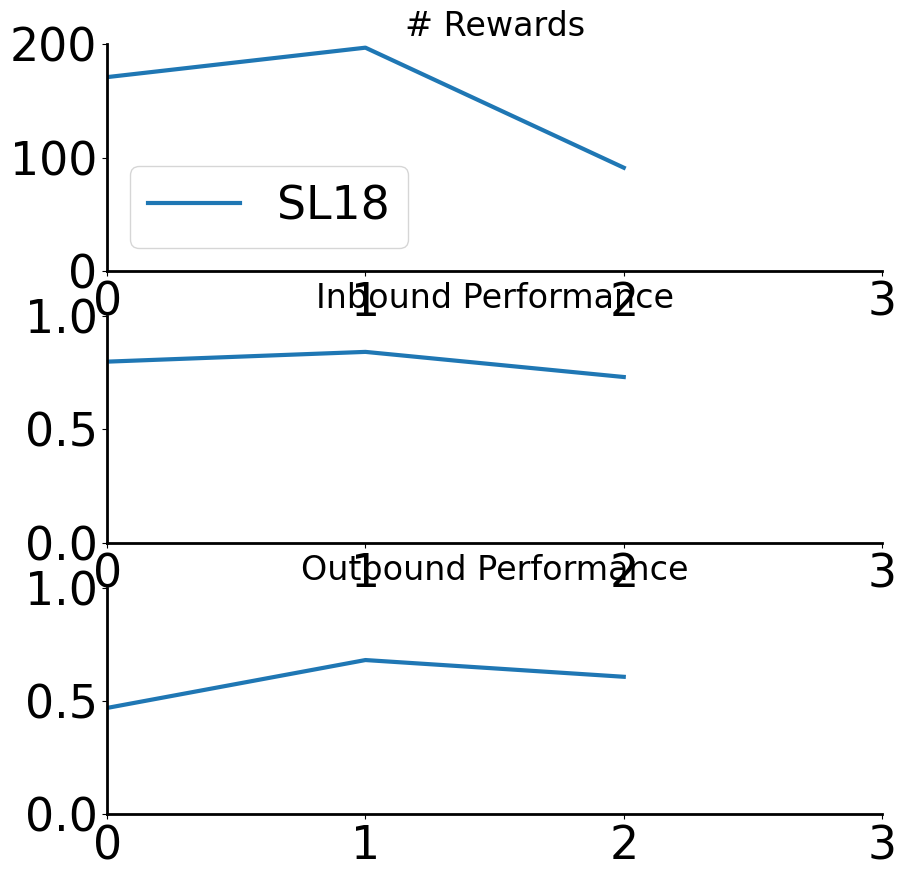

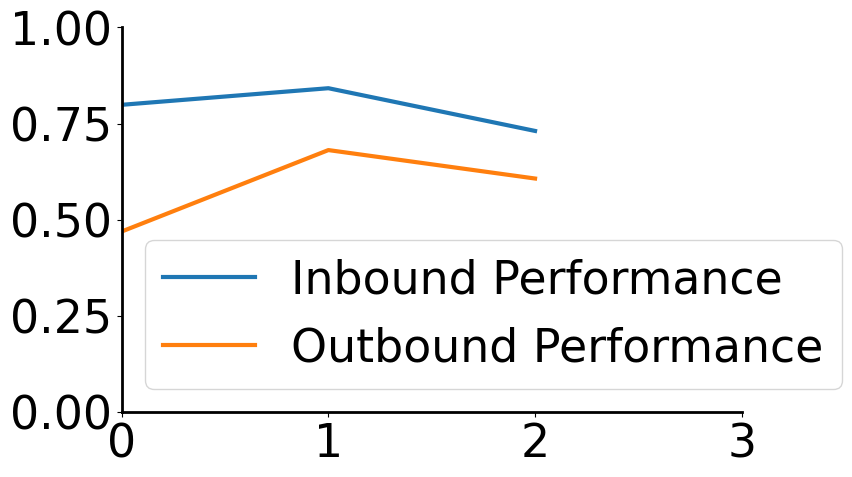

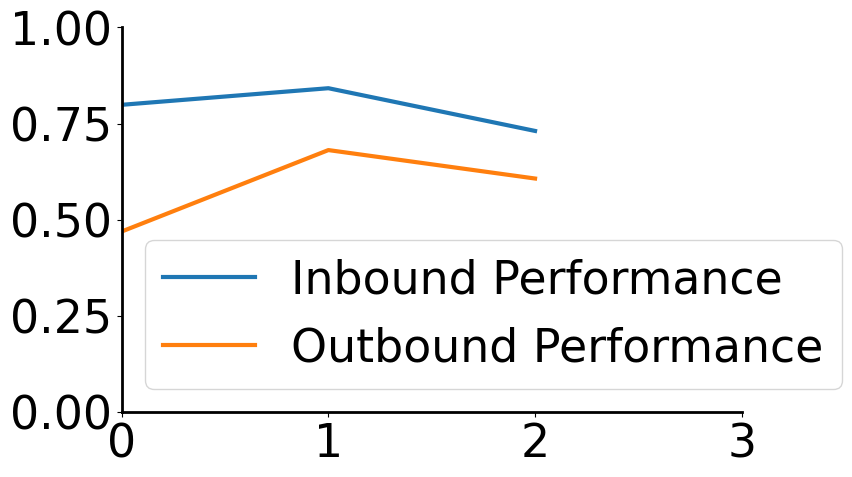

In [8]:
BehGraph.plotInboundOutboundPerformance(SubLearnImplantedRats)
